In [1]:
import datetime
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler

In [2]:
warnings.filterwarnings('ignore')

## Data load & merge

### Machine data

In [3]:
machine = pd.read_csv('./data/machine_master.csv')
machine.head()

,M_ID,Type,Age
0,1,3,18
1,2,4,7
2,3,3,8
3,4,3,7
4,5,3,2


In [4]:
machine.shape

(100, 3)

In [5]:
# Type는 4가지
machine.Type.unique()

array([3, 4, 2, 1])

### Maint data

In [6]:
maint = pd.read_csv('./data/maint_log.csv')
maint.head()

,DateTime,M_ID,Comp_ID
0,6/1/2014 6:00:00 AM,1,C02
1,7/16/2014 6:00:00 AM,1,C04
2,7/31/2014 6:00:00 AM,1,C03
3,12/13/2014 6:00:00 AM,1,C01
4,1/5/2015 6:00:00 AM,1,C04


In [7]:
maint.shape

(3286, 3)

In [8]:
# datetime 변환
maint['DateTime'] = pd.to_datetime(maint['DateTime'], format="%m/%d/%Y %I:%M:%S %p")

In [9]:
# maint는 모두 06:00 수행됨
maint[maint['DateTime'].apply(lambda x:x.strftime('%I:%M:%S')) != '06:00:00']

,DateTime,M_ID,Comp_ID


In [10]:
for ma in maint.Comp_ID.unique():
    maint[f'maint_{ma}'] = np.where(maint.Comp_ID==ma, 1, 0)

In [11]:
maint

,DateTime,M_ID,Comp_ID,maint_C02,maint_C04,maint_C03,maint_C01
0,2014-06-01 06:00:00,1,C02,1,0,0,0
1,2014-07-16 06:00:00,1,C04,0,1,0,0
2,2014-07-31 06:00:00,1,C03,0,0,1,0
3,2014-12-13 06:00:00,1,C01,0,0,0,1
4,2015-01-05 06:00:00,1,C04,0,1,0,0
...,...,...,...,...,...,...,...
3281,2015-10-10 06:00:00,100,C03,0,0,1,0
3282,2015-10-25 06:00:00,100,C04,0,1,0,0
3283,2015-11-09 06:00:00,100,C04,0,1,0,0
3284,2015-12-09 06:00:00,100,C02,1,0,0,0


In [12]:
# 날짜 / Machine 기준 중복이 있는 행
maint_duplicated = pd.concat([maint[maint.duplicated(subset=['DateTime', 'M_ID'], keep='first')], maint[maint.duplicated(subset=['DateTime', 'M_ID'], keep='last')]]).sort_values(by=['DateTime'])

In [13]:
maint_duplicated

,DateTime,M_ID,Comp_ID,maint_C02,maint_C04,maint_C03,maint_C01
628,2014-06-01 06:00:00,20,C01,0,0,0,1
629,2014-06-01 06:00:00,20,C02,1,0,0,0
274,2014-06-01 06:00:00,9,C01,0,0,0,1
275,2014-06-01 06:00:00,9,C02,1,0,0,0
1778,2014-06-16 06:00:00,55,C01,0,0,0,1
...,...,...,...,...,...,...,...
2103,2015-12-31 06:00:00,64,C03,0,0,1,0
503,2015-12-31 06:00:00,15,C02,1,0,0,0
2776,2015-12-31 06:00:00,84,C02,1,0,0,0
2102,2015-12-31 06:00:00,64,C01,0,0,0,1


In [14]:
# DateTime, M_ID 별 grouping
maint_grouped = maint_duplicated.groupby(['DateTime', 'M_ID']).sum()

In [15]:
# Encoding column Merge
for i in maint_grouped.index:
    sub_df = maint_duplicated[(maint_duplicated['DateTime']==i[0]) & (maint_duplicated['M_ID']==i[1])]
    for c in maint_grouped.columns:
        maint.loc[sub_df.index, c] = maint_grouped.loc[(i[0], i[1]), c]
        
maint = maint.drop('Comp_ID', axis=1)
maint = maint.drop_duplicates(subset=['DateTime', 'M_ID'])

In [16]:
maint.shape

(2528, 6)

In [17]:
# 동시에 발생하는 케이스 발견
maint.iloc[:, -4:].sum(axis=1).value_counts()

1    1772
2     754
4       2
dtype: int64

### Measure data

In [18]:
measures = pd.read_csv('./data/measures_log.csv')
measures.head()

,DateTime,M_ID,X1,X2,X3,X4
0,1/1/2015 6:00:00 AM,1,176.217853,418.504078,113.077935,45.087686
1,1/1/2015 7:00:00 AM,1,162.879223,402.747490,95.460525,43.413973
2,1/1/2015 8:00:00 AM,1,170.989902,527.349825,75.237905,34.178847
3,1/1/2015 9:00:00 AM,1,162.462833,346.149335,109.248561,41.122144
4,1/1/2015 10:00:00 AM,1,157.610021,435.376873,111.886648,25.990511


In [19]:
measures.shape

(876100, 6)

In [20]:
# datetime 변환
measures['DateTime'] = pd.to_datetime(measures['DateTime'], format="%m/%d/%Y %I:%M:%S %p")

In [21]:
def convert_string_to_timedelta(string):
    # type: (str) -> datetime.timedelta
    if not string:
        raise ValueError('{} is not a valid timedelta string'.format(string))
    
    # get days
    tmp = string.split('.')
    if len(tmp) == 2:
        days = int(tmp[0])
        tmp = tmp[1]
    elif len(tmp) == 1:
        days = 0
        tmp = tmp[0]
    else:
        raise ValueError('{} is not a valid timedelta string'.format(string))
    # get total seconds
    tmp = tmp.split(':')
    if len(tmp) != 3:
        raise ValueError('{} is not a valid timedelta string'.format(string))
    totsec = int(tmp[2]) + int(tmp[1]) * 60 + int(tmp[0]) * 3600
        
    return datetime.timedelta(days, totsec)

In [22]:
# time diff 계산
diff_day = measures['DateTime'] - measures['DateTime'].shift(1)

# time diff가 1시간 이상인 index 추출
big_diff_list = [i for i in diff_day.index if diff_day[i] > convert_string_to_timedelta('01:00:00')]

In [23]:
# 튀는 값 없음
big_diff_list

[]

In [24]:
# 측정은 모두 정각에 수행됨
measures[measures['DateTime'].apply(lambda x:x.strftime('%M:%S')) != '00:00']

,DateTime,M_ID,X1,X2,X3,X4


### Error data

In [25]:
error = pd.read_csv('./data/err_log.csv')
error.head()

,DateTime,M_ID,Err_ID
0,1/3/2015 7:00:00 AM,1,E01
1,1/3/2015 8:00:00 PM,1,E03
2,1/4/2015 6:00:00 AM,1,E05
3,1/10/2015 3:00:00 PM,1,E04
4,1/22/2015 10:00:00 AM,1,E04


In [26]:
error.shape

(3919, 3)

In [27]:
# datetime 변환
error['DateTime'] = pd.to_datetime(error['DateTime'], format="%m/%d/%Y %I:%M:%S %p")

In [28]:
# one-hot
for err in error.Err_ID.unique():
    error[f'error_{err}'] = np.where(error.Err_ID==err, 1, 0)

In [29]:
# 날짜 / Machine 기준 중복이 있는 행
error_duplicated = pd.concat([error[error.duplicated(subset=['DateTime', 'M_ID'], keep='first')], error[error.duplicated(subset=['DateTime', 'M_ID'], keep='last')]]).sort_values(by=['DateTime']).drop_duplicates()

In [30]:
# DateTime, M_ID 별 grouping
error_grouped = error_duplicated.groupby(['DateTime', 'M_ID']).sum()

In [31]:
# Encoding column Merge
for i in error_grouped.index:
    sub_df = error_duplicated[(error_duplicated['DateTime']==i[0]) & (error_duplicated['M_ID']==i[1])]
    for c in error_grouped.columns:
        error.loc[sub_df.index, c] = error_grouped.loc[(i[0], i[1]), c]
        
error = error.drop('Err_ID', axis=1)
error = error.drop_duplicates(subset=['DateTime', 'M_ID'])

In [32]:
error

,DateTime,M_ID,error_E01,error_E03,error_E05,error_E04,error_E02
0,2015-01-03 07:00:00,1,1,0,0,0,0
1,2015-01-03 20:00:00,1,0,1,0,0,0
2,2015-01-04 06:00:00,1,0,0,1,0,0
3,2015-01-10 15:00:00,1,0,0,0,1,0
4,2015-01-22 10:00:00,1,0,0,0,1,0
...,...,...,...,...,...,...,...
3913,2015-11-12 01:00:00,100,1,0,0,0,0
3914,2015-11-21 08:00:00,100,0,0,0,0,1
3915,2015-12-04 02:00:00,100,1,0,0,0,0
3916,2015-12-08 06:00:00,100,0,1,0,0,1


In [33]:
# 동시에 발생하는 에러 케이스 발견
error.iloc[:, -5:].sum(axis=1).value_counts()

1    3342
2     245
3      29
dtype: int64

### Fail data

In [34]:
fail = pd.read_csv('./data/fail_log.csv')
fail.head()

,DateTime,M_ID,Comp_ID
0,1/5/2015 6:00:00 AM,1,C04
1,3/6/2015 6:00:00 AM,1,C01
2,4/20/2015 6:00:00 AM,1,C02
3,6/19/2015 6:00:00 AM,1,C04
4,9/2/2015 6:00:00 AM,1,C04


In [35]:
# datetime 변환
fail['DateTime'] = pd.to_datetime(fail['DateTime'], format="%m/%d/%Y %I:%M:%S %p")

In [36]:
for fa in fail.Comp_ID.unique():
    fail[f'fail_{fa}'] = np.where(fail.Comp_ID==fa, 1, 0)

In [37]:
fail

,DateTime,M_ID,Comp_ID,fail_C04,fail_C01,fail_C02,fail_C03
0,2015-01-05 06:00:00,1,C04,1,0,0,0
1,2015-03-06 06:00:00,1,C01,0,1,0,0
2,2015-04-20 06:00:00,1,C02,0,0,1,0
3,2015-06-19 06:00:00,1,C04,1,0,0,0
4,2015-09-02 06:00:00,1,C04,1,0,0,0
...,...,...,...,...,...,...,...
756,2015-11-29 06:00:00,99,C03,0,0,0,1
757,2015-12-14 06:00:00,99,C04,1,0,0,0
758,2015-02-12 06:00:00,100,C01,0,1,0,0
759,2015-09-10 06:00:00,100,C01,0,1,0,0


In [38]:
# 날짜 / Machine 기준 중복이 있는 행
fail_duplicated = pd.concat([fail[fail.duplicated(subset=['DateTime', 'M_ID'], keep='first')], fail[fail.duplicated(subset=['DateTime', 'M_ID'], keep='last')]]).sort_values(by=['DateTime']).drop_duplicates()

In [39]:
fail_duplicated

,DateTime,M_ID,Comp_ID,fail_C04,fail_C01,fail_C02,fail_C03
95,2015-01-02 03:00:00,16,C03,0,0,0,1
94,2015-01-02 03:00:00,16,C01,0,1,0,0
65,2015-01-07 06:00:00,12,C02,0,0,1,0
64,2015-01-07 06:00:00,12,C01,0,1,0,0
384,2015-01-19 06:00:00,52,C04,1,0,0,0
...,...,...,...,...,...,...,...
291,2015-12-13 06:00:00,38,C04,1,0,0,0
81,2015-12-22 06:00:00,13,C01,0,1,0,0
82,2015-12-22 06:00:00,13,C02,0,0,1,0
608,2015-12-27 06:00:00,83,C02,0,0,1,0


In [40]:
# DateTime, M_ID 별 grouping
fail_grouped = fail_duplicated.groupby(['DateTime', 'M_ID']).sum()

In [41]:
# Encoding column Merge
for i in fail_grouped.index:
    sub_df = fail_duplicated[(fail_duplicated['DateTime']==i[0]) & (fail_duplicated['M_ID']==i[1])]
    for c in fail_grouped.columns:
        fail.loc[sub_df.index, c] = fail_grouped.loc[(i[0], i[1]), c]
        
fail = fail.drop('Comp_ID', axis=1)
fail = fail.drop_duplicates(subset=['DateTime', 'M_ID'])

In [42]:
# fail은 최대 2건까지 발생
fail.iloc[:, -4:].sum(axis=1).value_counts()

1    677
2     42
dtype: int64

In [43]:
# 03:00에 fail 이력이 찍힌 경우가 있음. 이 날에 component 교체가 있었는지 확인 필요
fail[fail['DateTime'].apply(lambda x:x.strftime('%I:%M:%S')) != '06:00:00']

,DateTime,M_ID,fail_C04,fail_C01,fail_C02,fail_C03
94,2015-01-02 03:00:00,16,0,1,0,1
107,2015-01-02 03:00:00,17,1,0,0,0
161,2015-01-02 03:00:00,22,0,1,0,0
256,2015-01-02 03:00:00,35,0,1,0,0
331,2015-01-02 03:00:00,45,0,1,0,0
373,2015-01-02 03:00:00,51,0,1,0,0
409,2015-01-02 03:00:00,56,0,0,0,1
422,2015-01-02 03:00:00,58,0,0,1,0
430,2015-01-02 03:00:00,59,0,1,0,0
523,2015-01-02 03:00:00,73,0,0,1,0


### Data Merge

In [44]:
measure_data = pd.merge(measures, machine, how='left', on='M_ID')
measure_data = pd.merge(measure_data, maint, how='left', on=['DateTime', 'M_ID'])
measure_data = pd.merge(measure_data, error, how='left', on=['DateTime', 'M_ID'])
measure_data = pd.merge(measure_data, fail, how='left', on=['DateTime', 'M_ID'])

In [45]:
# Fill Categorical data's NA
measure_data.iloc[:, 8:] = measure_data.iloc[:, 8:].fillna(0).astype(int)

In [46]:
component = ['C01', 'C02', 'C03', 'C04']
fail_col = ['fail_' + c for c in component]
maint_col = ['maint_' + c for c in component]
error_col = ['error_' + e for e in ['E01', 'E02', 'E03', 'E04', 'E05']]

In [47]:
maint_check = measure_data.loc[:, ['DateTime', 'M_ID'] + maint_col + fail_col]

In [48]:
# 03:00에 fail log가 있는 Machine
maint_check[maint_check.DateTime=='2015-01-02 03:00:00'][maint_check.iloc[:, 2:].any(axis=1)].M_ID.unique()

array([16, 17, 22, 35, 45, 51, 56, 58, 59, 73, 79, 80, 83, 86, 87, 94, 99])

In [49]:
len(maint_check[maint_check.DateTime=='2015-01-02 03:00:00'][maint_check.iloc[:, 2:].any(axis=1)])

17

In [50]:
# 같은 날 06:00에 fail log가 있는 Machine
# 73, 79는 겹침
maint_check[maint_check.DateTime=='2015-01-02 06:00:00'][maint_check.iloc[:, 2:].any(axis=1)].M_ID.unique()

array([24, 29, 68, 73, 79, 81])

In [51]:
# 기존의 06:00 data
maint_check[maint_check.DateTime=='2015-01-02 06:00:00'][maint_check.iloc[:, 2:].any(axis=1)]

,DateTime,M_ID,maint_C01,maint_C02,maint_C03,maint_C04,fail_C01,fail_C02,fail_C03,fail_C04
201527,2015-01-02 06:00:00,24,1,1,0,0,1,0,0,0
245332,2015-01-02 06:00:00,29,0,1,0,0,0,0,0,0
587011,2015-01-02 06:00:00,68,1,0,0,0,0,0,0,0
630816,2015-01-02 06:00:00,73,1,0,1,0,0,0,1,0
683382,2015-01-02 06:00:00,79,0,0,1,0,0,0,0,0
700904,2015-01-02 06:00:00,81,1,0,1,0,1,0,0,0


In [52]:
# 03:00의 fail data를 06:00으로 이동
for i in maint_check[maint_check.DateTime=='2015-01-02 03:00:00'][maint_check.iloc[:, 2:].any(axis=1)].index:
    fail_any_series = pd.DataFrame([maint_check.loc[i, fail_col], maint_check.loc[i + 3, fail_col]]).any()
    for col in fail_col:
        measure_data.loc[i + 3, col] = np.where(fail_any_series[col], 1, 0)
        measure_data.loc[i, col] = 0

In [53]:
# 다시 check
maint_check = measure_data.loc[:, ['DateTime', 'M_ID'] + maint_col + fail_col]
maint_check[maint_check.DateTime=='2015-01-02 03:00:00'][maint_check.iloc[:, 2:].any(axis=1)]

,DateTime,M_ID,maint_C01,maint_C02,maint_C03,maint_C04,fail_C01,fail_C02,fail_C03,fail_C04


In [54]:
len(maint_check[maint_check.DateTime=='2015-01-02 06:00:00'][maint_check.iloc[:, 2:].any(axis=1)])

21

## EDA

In [55]:
comp_list = ['C01', 'C02', 'C03', 'C04']
var_list = ['X1', 'X2', 'X3', 'X4']

In [56]:
fail_cols = ['fail_' + comp for comp in comp_list]
maint_cols = ['maint_' + comp for comp in comp_list]
error_cols = ['error_E01', 'error_E02', 'error_E03', 'error_E04', 'error_E05']

In [57]:
# Create a new column for the date
measure_data['Date'] = pd.to_datetime(measure_data['DateTime']).dt.date

# Create a new column for the day of the week
measure_data['day_of_week'] = pd.to_datetime(measure_data['DateTime']).dt.dayofweek

### Data split

In [86]:
### Train, Validation 분할
train_data = measure_data[measure_data.DateTime < '2015-12-01']
valid_data = measure_data[measure_data.DateTime >= '2015-12-01']

In [59]:
train_data.reset_index(inplace=True, drop=True)
valid_data.reset_index(inplace=True, drop=True)

In [ ]:
# temp save
measure_data.to_csv('./data/machine_merged.csv', index=False)

### Baseline cost

In [90]:
### Valid data의 Baseline 비용 계산
# 컴포넌트가 동시에 고장나는 경우에도 고장 손실 비용은 100만원. 고장이 난 것 자체가 중요한 상황.

# 고장에 의한 손실 비용 계산
fail_loss = 100 * (valid_data.loc[:, fail_cols].sum(axis=1).value_counts()[1:].sum())
print('고장에 의한 비용:', fail_loss)

# 고장에 의한 컴포넌트 교체 비용 계산
comp_cost = [15, 30, 20, 25]
fail_comp_cost_sum = 0
for i, col in enumerate(fail_cols):
    fail_comp_cost_sum += valid_data.loc[:, col].sum() * comp_cost[i]

print('컴포넌트 고장 교체 비용:', comp_cost_sum)

# 정기 교체 비용. 고장에 의한 교체와 동시에 일어난 경우 한 번만 발생한 것으로 생각해야 함
# 수정 예정
maint_comp_cost_sum = 0
for i, col in enumerate(maint_cols):
    if fail_cols[i]
    maint_comp_cost_sum += valid_data.loc[:, col].sum() * comp_cost[i]

print('컴포넌트 정기 교체 비용:', fail_comp_cost_sum)

고장에 의한 비용: 5600
컴포넌트 고장 교체 비용: 1395
컴포넌트 정기 교체 비용: 1395


In [62]:
fail_loss + comp_cost_sum + fail_comp_cost_sum

12695

#### Measures 변수의 분포 확인

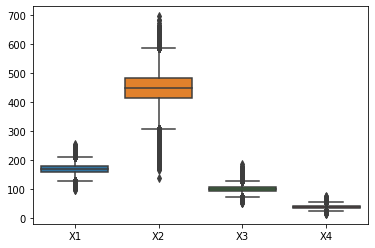

In [63]:
### scale 다르고, outlier 존재함
sns.boxplot(data=train_data.loc[:, var_list])
plt.show()

In [64]:
### 거의 좌우 대칭. 변환은 딱히 필요하지 않을 듯.
for var in var_list:
    print('Skew', var, ':', train_data[var].skew())

Skew X1 : 0.08616592727373588
Skew X2 : -0.14348600607198259
Skew X3 : 0.4004280607063879
Skew X4 : 0.24654402361088987


In [65]:
### 각 기계별로 scaling 필요. 기계가 다르면 센서도 달라진다.
# 기계 단위로 split 한 다음 다시 merge.
# Outlier가 있으므로 RobustScaler 적용.
scaled_train_data = pd.DataFrame()
scaled_valid_data = pd.DataFrame()
for m_id in train_data.M_ID.unique():
    tmp_train_data = train_data[train_data.M_ID==m_id]
    tmp_valid_data = valid_data[valid_data.M_ID==m_id]
    
    scaler = RobustScaler()
    train_s = scaler.fit_transform(tmp_train_data.loc[:, var_list])
    val_s = scaler.transform(tmp_valid_data.loc[:, var_list])
    
    scaled_train_data = pd.concat([scaled_train_data, pd.DataFrame(train_s, columns=var_list)])
    scaled_valid_data = pd.concat([scaled_valid_data, pd.DataFrame(val_s, columns=var_list)])

In [66]:
scaled_train_data.reset_index(inplace=True, drop=True)
scaled_valid_data.reset_index(inplace=True, drop=True)

In [67]:
for var in var_list:
    train_data[var] = scaled_train_data[var]
    valid_data[var] = scaled_valid_data[var]

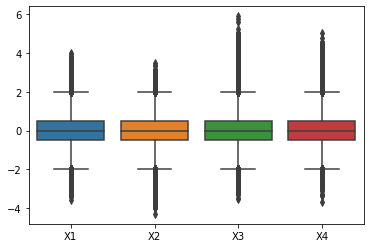

In [68]:
### scale 완료
sns.boxplot(data=train_data.loc[:, var_list])
plt.show()

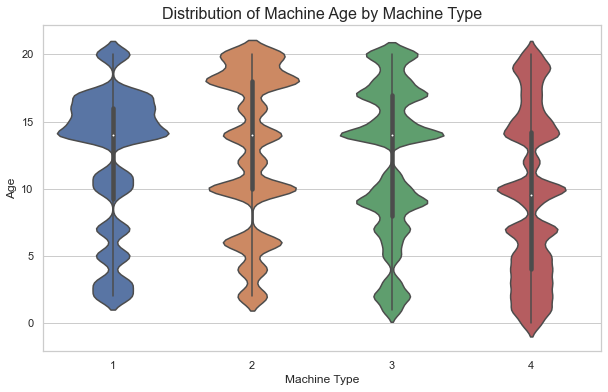

In [69]:
# 기계 연식 시각화
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Type", y="Age", data=train_data)

# Set the title and labels
plt.title("Distribution of Machine Age by Machine Type", fontsize=16)
plt.xlabel("Machine Type", fontsize=12)
plt.ylabel("Age", fontsize=12)

# Show the plot
plt.show()

In [70]:
### 연식이 높을 수록 fail_C03과 fail_C04의 발생이 커지는 경향이 있음
correlation_age_failures_types = {}

for fail_type in fail_cols:
    grouped_data_failures_type = train_data.groupby(['M_ID', 'Age'])[fail_type].sum().reset_index()
    correlation_age_failures_types[fail_type] = grouped_data_failures_type['Age'].corr(grouped_data_failures_type[fail_type])

correlation_age_failures_types

{'fail_C01': -0.05952399217143976,
 'fail_C02': -0.024346885417601643,
 'fail_C03': 0.12234419714260929,
 'fail_C04': 0.8081871085363157}

<AxesSubplot:>

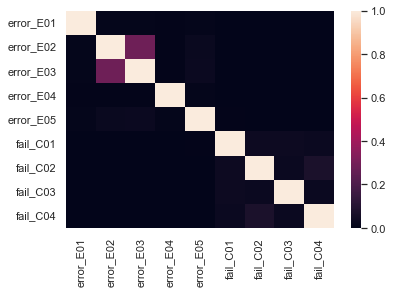

In [71]:
# error와 fail의 상관관계
# error 2와 3이 상관관계가 있고, 나머지는 상관관계가 없음
sns.heatmap(train_data.loc[:, error_cols + fail_cols].corr())

<AxesSubplot:>

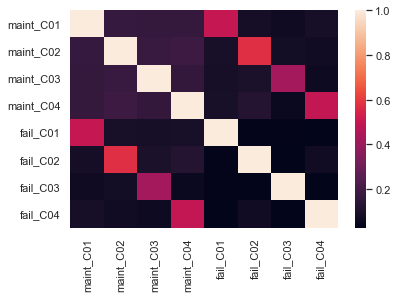

In [72]:
# maint와 fail의 상관관계
# 각 component 별로 0.4~0.6 정도의 상관관계 있음 확인
# fail -> mnt 관계가 있기 때문
sns.heatmap(train_data.loc[:, maint_cols + fail_cols].corr())

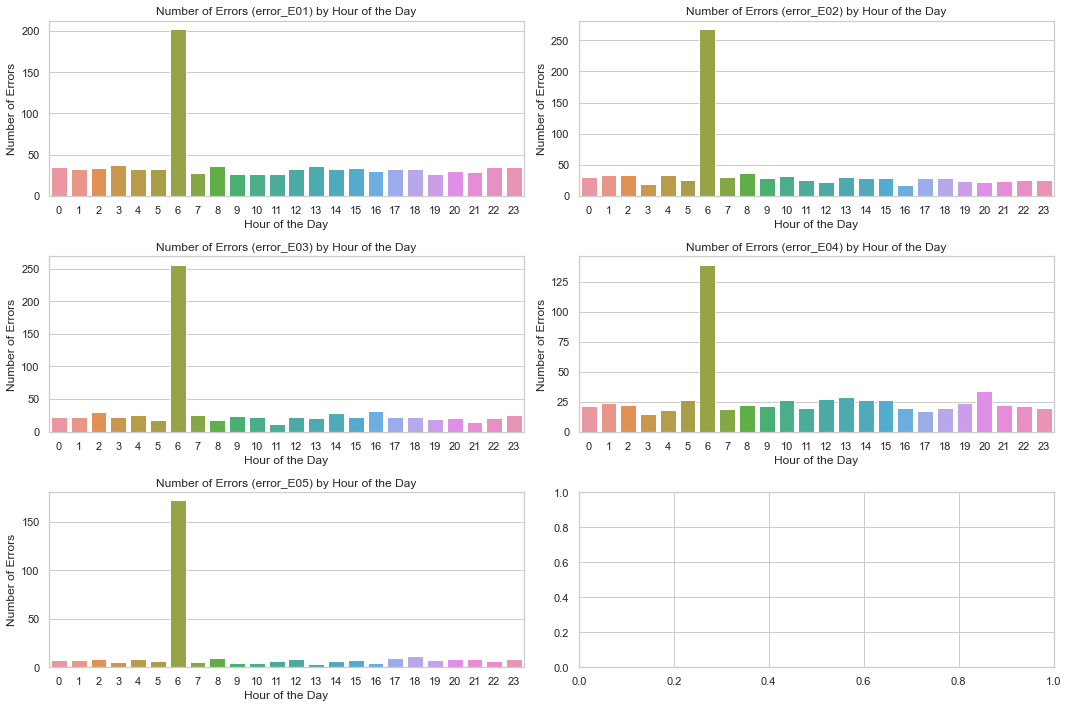

In [73]:
# 시간대 별 error 시각화
# Calculate the number of errors for each hour of the day and each type of error
train_data['hour_of_day'] = pd.to_datetime(train_data['DateTime']).dt.hour
errors_by_hour_of_day_and_type = train_data.groupby('hour_of_day')[error_cols].sum()

# Create a bar plot for each type of error
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()
for i, error_col in enumerate(error_cols):
    ax = axes[i]
    sns.barplot(x=errors_by_hour_of_day_and_type.index, y=errors_by_hour_of_day_and_type[error_col], ax=ax)
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Number of Errors')
    ax.set_title('Number of Errors (' + error_col + ') by Hour of the Day')
plt.tight_layout()
plt.show()

# error는 6시에 많이 발생한다. why?
# fail의 경우 무조건 6시에만 발생(하도록 데이터 변경)함

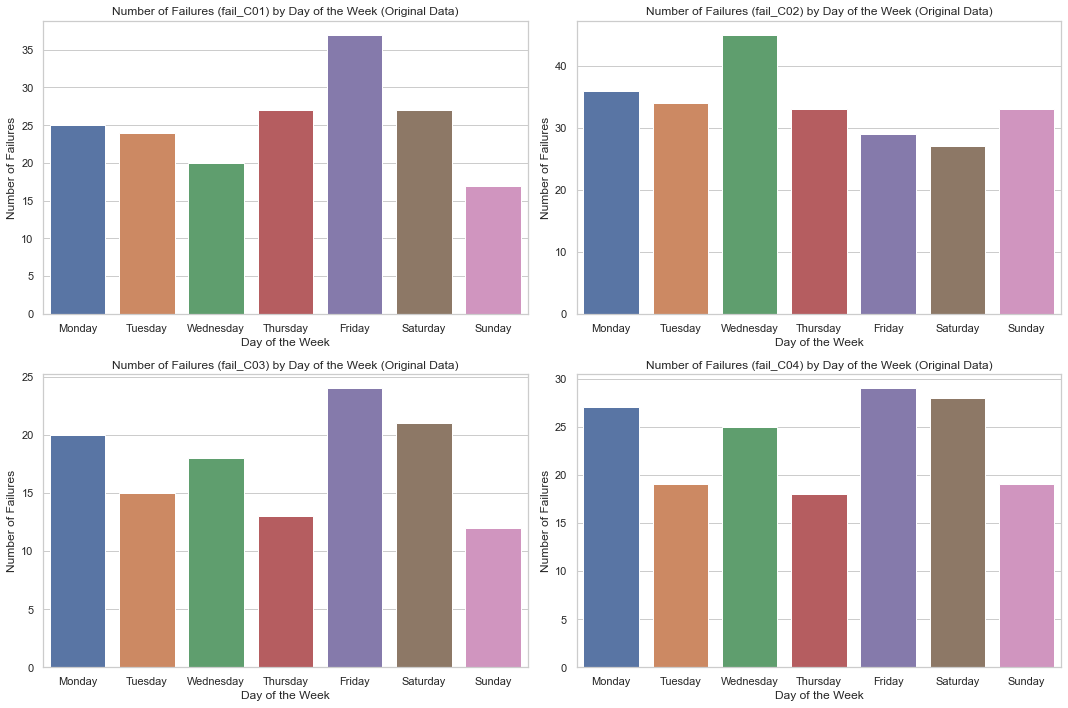

In [74]:
# 요일 별 fail 발생 횟수
# 유의미한 결과를 찾기는 어려웠음
# Calculate the number of failures for each day of the week and each type of failure
failures_by_day_of_week_and_type_original = train_data.groupby('day_of_week')[fail_cols].sum()

# Create a bar plot for each type of failure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()
for i, fail_col in enumerate(fail_cols):
    ax = axes[i]
    sns.barplot(x=failures_by_day_of_week_and_type_original.index, y=failures_by_day_of_week_and_type_original[fail_col], ax=ax)
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Number of Failures')
    ax.set_title('Number of Failures (' + fail_col + ') by Day of the Week (Original Data)')
    ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.tight_layout()
plt.show()

In [75]:
from scipy.stats import chi2_contingency

# 요일 별 발생횟수의 차이 검정 -> 귀무가설 기각되지 않음
# Create a contingency table for failures by day of the week
train_data['Day'] = train_data['DateTime'].dt.dayofweek
train_data['Total_Fails'] = train_data[fail_cols].sum(axis=1)
contingency_table = pd.crosstab(train_data['Day'], train_data['Total_Fails'] > 0)

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

chi2, p

(7.196188497992976, 0.3030844155559602)

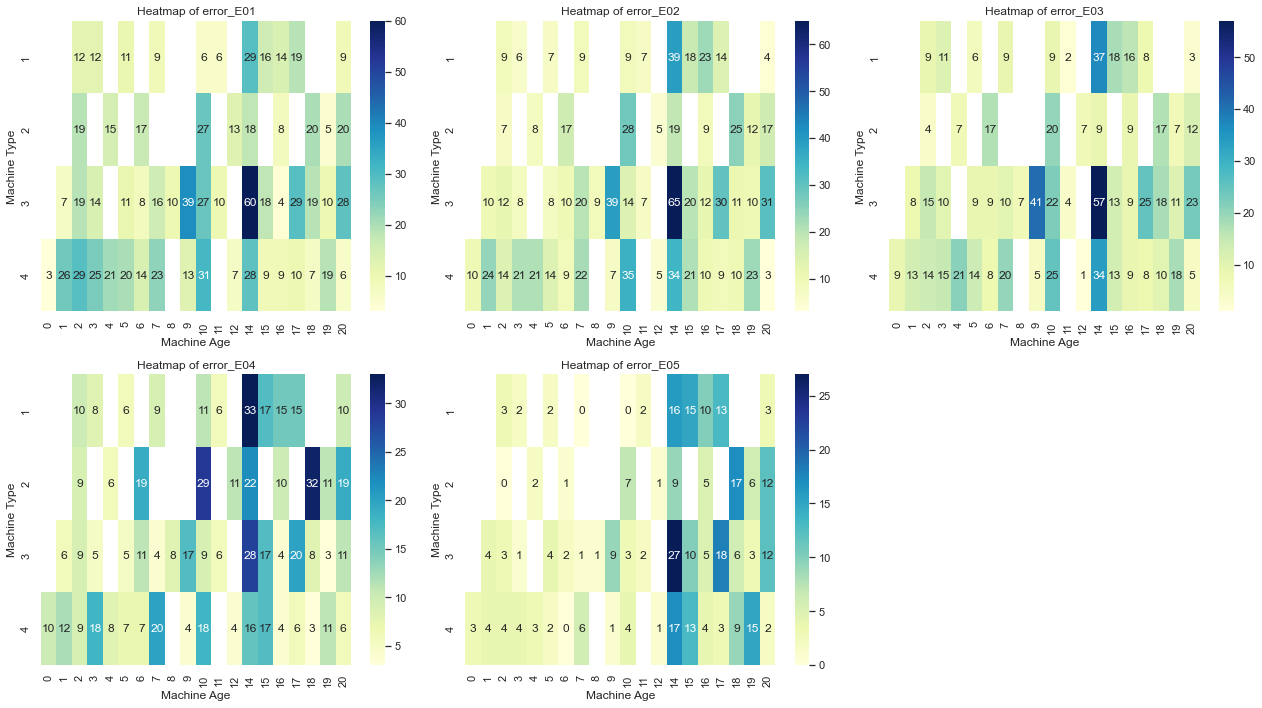

In [76]:
# 연식, 타입 별 error 발생 횟수
# Create a heatmap for each type of error with swapped axes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, error_col in enumerate(error_cols):
    ax = axes[i]
    errors_by_type_and_age = train_data.groupby(['Type', 'Age'])[error_cols].sum().reset_index()
    pivot_table = errors_by_type_and_age.pivot(index='Type', columns='Age', values=error_col)
    sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".0f", ax=ax)
    ax.set_xlabel('Machine Age')
    ax.set_ylabel('Machine Type')
    ax.set_title('Heatmap of ' + error_col)

# Remove the last subplot as it is not used
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

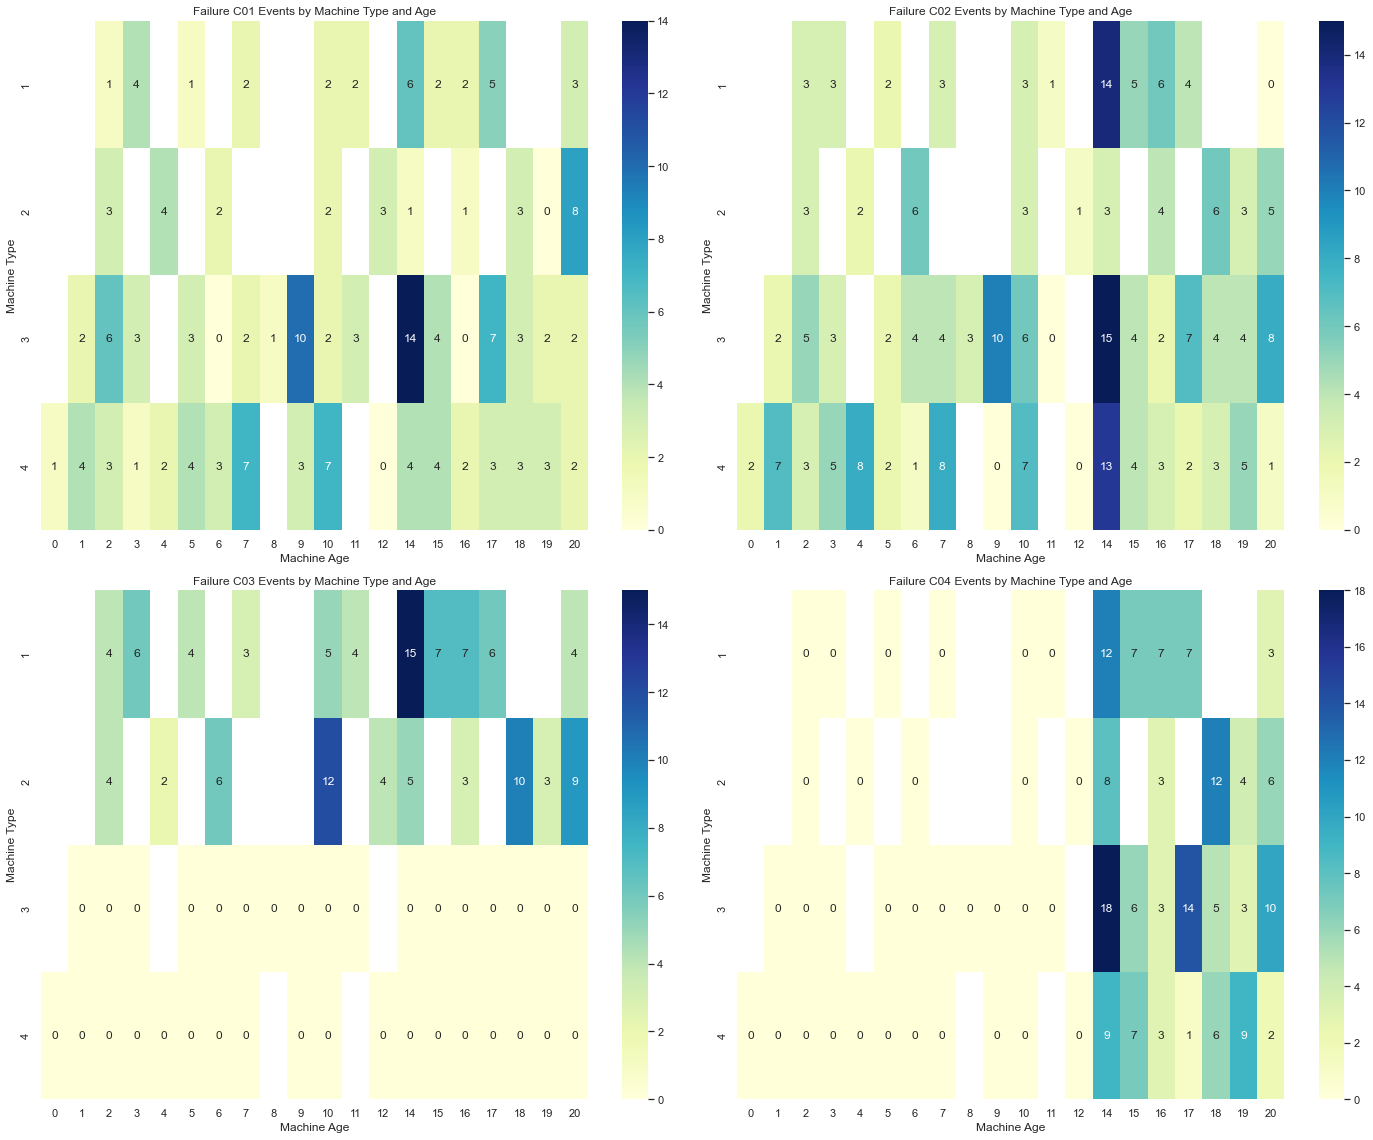

In [77]:
# 연식, 타입 별 fail 발생 횟수
# Group the data by Machine Type and Age, and calculate the sum of each failure type for each group
grouped_data_fail_C01 = train_data.groupby(['Type', 'Age'])['fail_C01'].sum().reset_index()
grouped_data_fail_C02 = train_data.groupby(['Type', 'Age'])['fail_C02'].sum().reset_index()
grouped_data_fail_C03 = train_data.groupby(['Type', 'Age'])['fail_C03'].sum().reset_index()
grouped_data_fail_C04 = train_data.groupby(['Type', 'Age'])['fail_C04'].sum().reset_index()

# Create pivot tables for the heatmaps
pivot_table_fail_C01 = grouped_data_fail_C01.pivot('Type', 'Age', 'fail_C01')
pivot_table_fail_C02 = grouped_data_fail_C02.pivot('Type', 'Age', 'fail_C02')
pivot_table_fail_C03 = grouped_data_fail_C03.pivot('Type', 'Age', 'fail_C03')
pivot_table_fail_C04 = grouped_data_fail_C04.pivot('Type', 'Age', 'fail_C04')

# Generate heatmaps
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

sns.heatmap(pivot_table_fail_C01, annot=True, fmt=".0f", cmap='YlGnBu', ax=axes[0, 0])
axes[0, 0].set_title('Failure C01 Events by Machine Type and Age')
axes[0, 0].set_xlabel('Machine Age')
axes[0, 0].set_ylabel('Machine Type')

sns.heatmap(pivot_table_fail_C02, annot=True, fmt=".0f", cmap='YlGnBu', ax=axes[0, 1])
axes[0, 1].set_title('Failure C02 Events by Machine Type and Age')
axes[0, 1].set_xlabel('Machine Age')
axes[0, 1].set_ylabel('Machine Type')

sns.heatmap(pivot_table_fail_C03, annot=True, fmt=".0f", cmap='YlGnBu', ax=axes[1, 0])
axes[1, 0].set_title('Failure C03 Events by Machine Type and Age')
axes[1, 0].set_xlabel('Machine Age')
axes[1, 0].set_ylabel('Machine Type')

sns.heatmap(pivot_table_fail_C04, annot=True, fmt=".0f", cmap='YlGnBu', ax=axes[1, 1])
axes[1, 1].set_title('Failure C04 Events by Machine Type and Age')
axes[1, 1].set_xlabel('Machine Age')
axes[1, 1].set_ylabel('Machine Type')

plt.tight_layout()
plt.show()

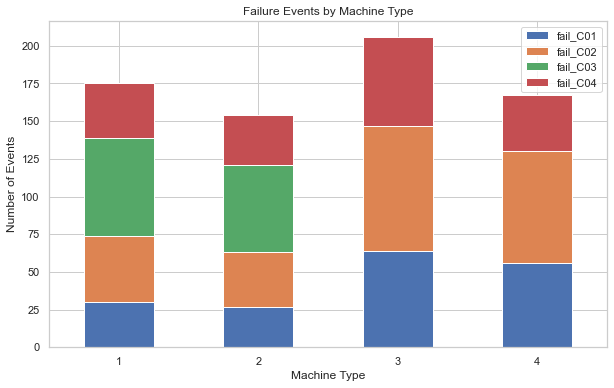

In [78]:
# 다른 시각화: 기계 종류 별 고장의 유형
# 기계 종류 3, 4는 3번 component fail이 발생하지 않음
# Group the data by Machine Type, and calculate the sum of each failure type for each group
grouped_data_fail = train_data.groupby('Type')[fail_cols].sum()

# Generate a bar plot
grouped_data_fail.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Failure Events by Machine Type')
plt.xlabel('Machine Type')
plt.ylabel('Number of Events')
plt.xticks(rotation=0)
plt.show()

In [79]:
### error와 다음 날 fail의 발생 빈도
total_fails = train_data[fail_cols].sum()

# Initialize a dictionary to store results
fail_after_specific_error = {}

# Loop through each error column
for error in error_cols:
    # Shift the error column to get errors from the previous day
    train_data['Specific_Error_Previous_Day'] = train_data.groupby('M_ID')[error].shift()

    # Count failures that occurred after a specific error
    fail_after_specific_error[error] = (train_data[train_data['Specific_Error_Previous_Day'] == 1][fail_cols].sum() / total_fails) * 100

fail_after_specific_error = pd.DataFrame(fail_after_specific_error).T
fail_after_specific_error

,fail_C01,fail_C02,fail_C03,fail_C04
error_E01,0.000000,0.0,0.813008,0.0
error_E02,0.000000,0.0,0.000000,0.0
error_E03,0.000000,0.0,0.000000,0.0
error_E04,0.564972,0.0,0.000000,0.0
error_E05,0.000000,0.0,0.813008,0.0


In [80]:
from scipy.stats import iqr

In [81]:
# For each maintenance and failure type
for maint_c, fail_c in zip(maint_cols, fail_cols):
    # Create new columns to store whether the maintenance was due to a failure
    measure_data[maint_c + '_and_' + fail_c] = (measure_data[maint_c] > 0) & (measure_data[fail_c] > 0)
    
# Convert the boolean values to integers (1 for True, 0 for False)
for col in measure_data.columns:
    if '_and_' in col:
        measure_data[col] = measure_data[col].astype(int)

In [82]:
measure_data['Date'] = pd.to_datetime(measure_data['DateTime'].dt.date)

# Function to detect outliers based on IQR
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = iqr(df[feature])
    
    # Define outliers
    lower_outliers = df[feature] < Q1 - 1.5 * IQR
    upper_outliers = df[feature] > Q3 + 1.5 * IQR
    
    return lower_outliers, upper_outliers

# outlier 개수 넣기
for feature in ['X1', 'X2', 'X3', 'X4']:
    lower_outliers, upper_outliers = detect_outliers(measure_data, feature)
    measure_data[f'lower_outlier_{feature}'] = lower_outliers
    measure_data[f'upper_outlier_{feature}'] = upper_outliers
    
### data 변형과 shift
agg_data = measure_data.groupby(['Date', 'M_ID']).agg({
    'X1': ['mean', 'median', 'max', 'min', 'std'],
    'X2': ['mean', 'median', 'max', 'min', 'std'],
    'X3': ['mean', 'median', 'max', 'min', 'std'],
    'X4': ['mean', 'median', 'max', 'min', 'std'],
    'maint_C01': 'sum',
    'maint_C02': 'sum',
    'maint_C03': 'sum',
    'maint_C04': 'sum',
    'error_E01': 'sum',
    'error_E02': 'sum',
    'error_E03': 'sum',
    'error_E04': 'sum',
    'fail_C01': 'sum',
    'fail_C02': 'sum',
    'fail_C03': 'sum',
    'fail_C04': 'sum',
    'lower_outlier_X1': 'sum',
    'lower_outlier_X2': 'sum',
    'lower_outlier_X3': 'sum',
    'lower_outlier_X4': 'sum',
    'upper_outlier_X1': 'sum',
    'upper_outlier_X2': 'sum',
    'upper_outlier_X3': 'sum',
    'upper_outlier_X4': 'sum'
}).reset_index()

# Flatten the column names
agg_data.columns = ['_'.join(col).strip() for col in agg_data.columns.values]
agg_data['Date'] = agg_data['Date_']
agg_data.drop('Date_', axis=1, inplace=True)

agg_data['NextDay'] = agg_data['Date'].dt.date + pd.DateOffset(days=1)
agg_data['M_ID'] = agg_data['M_ID_']
agg_data.drop('M_ID_', axis=1, inplace=True)
agg_data.drop('NextDay', axis=1, inplace=True)

# 컬럼명 변경
agg_data.columns = agg_data.columns.str.replace('_sum', '')

# 고장 컬럼 shift
# Converting DateTime from string to datetime format
for col in fail_cols:
    agg_data[col] = agg_data.groupby('M_ID')[col].shift(-1)
    
agg_data.dropna(inplace=True)

# Calculate Q1 and Q3 for each X variable for each date and machine
quantiles = measure_data.groupby(['Date', 'M_ID'])[var_list].quantile([0.25, 0.75]).unstack(level=2)

# Flatten the column names
quantiles.columns = ['_'.join([str(el) for el in col]) for col in quantiles.columns.values]

# Merge the quantiles with the aggregated data
agg_data = pd.merge(agg_data, quantiles, how='left', left_on=['Date', 'M_ID'], right_index=True)

In [83]:
def get_type(m_id):
    return type_agg.loc['2015-01-01', m_id].values[0]

In [84]:
# Type 변수 agg_data에 추가
agg_data['Type'] = agg_data['M_ID'].apply(get_type)

NameError: name 'type_agg' is not defined

In [ ]:
# Error의 경우 하루에 두 번 이상 발생한 경우가 존재함
count_check_columns = [col for col in agg_data.columns if 'error' in col or 'maint' in col or 'fail' in col]

# Check if any value is greater than 1
agg_data[count_check_columns].gt(1).sum()

In [ ]:
agg_data['maint_C01_and_fail_C01'].value_counts()

In [ ]:
# 발생 여부를 나타내는 컬럼은 category로 변경
# Identify the maintenance and failure columns
maint_columns = [col for col in agg_data.columns if 'maint' in col]
fail_columns = [col for col in agg_data.columns if 'fail' in col]

# Change these columns to category type
for col in maint_columns + fail_columns:
    agg_data[col] = agg_data[col].astype('category')
    
# M_ID도 category로 변경
agg_data['M_ID'] = agg_data['M_ID'].astype('category')
agg_data['Type'] = agg_data['Type'].astype('category')

# Check the data types to confirm
agg_data[maint_columns + fail_columns].dtypes

In [ ]:
agg_data.info()

In [ ]:
maint_columns

In [ ]:
# Function to calculate the number of days since the most recent maintenance
def days_since_most_recent_maint(df, maint_column):
    # Reverse the DataFrame (so we start from the end)
    # df = df[::-1]

    # Find where maintenance has occurred
    maint_days = df[maint_column] == 1

    # Calculate the number of days since the most recent maintenance

    days_since = maint_days.groupby((maint_days != maint_days.shift()).cumsum()).cumcount()

    # Reverse the results to match the original DataFrame
    days_since = days_since[::-1]

    return days_since

# Apply the function to each maintenance column
for col in maint_columns:
    agg_data[f'days_since_last_{col}'] = days_since_most_recent_maint(agg_data, col)

# Check the new columns
agg_data

In [ ]:
agg_data['fail_C02'].value_counts() # 

In [ ]:
agg_data['maint_C04_due_to_fail_C04'].value_counts()

In [ ]:
agg_data.info()

In [ ]:
agg_data['days_since_last_maint_C02_due_to_fail_C02'].value_counts()

In [ ]:
days_since_most_recent_maint(agg_data, 'maint_C01').cumcount()

In [ ]:
agg_data.to_csv('./data/machine_agg.csv', index=False)

In [ ]:
# Create a new dataframe to store the results
continuous_failures = pd.DataFrame()

# For each machine
for machine in agg_data['M_ID'].unique():
    # For each type of failure
    for fail_c in fail_col:
        # Get the dates when failures occurred
        fail_dates = agg_data.loc[(agg_data['M_ID'] == machine) & (agg_data[fail_c] > 0), 'Date'].sort_values()
        # Calculate the differences between consecutive failure dates
        fail_diffs = fail_dates.diff().dt.days
        # If there are any differences of 1 day (i.e., continuous failures)
        if any(fail_diffs == 1):
            # Add a row to the results dataframe
            continuous_failures = continuous_failures.append({'Machine': machine, 'Failure': fail_c, 'Continuous Failures': True}, ignore_index=True)

# Display the results
continuous_failures

In [ ]:
sns.lineplot(y='maint_C01_days_since', x='Date', data=agg_data[agg_data['M_ID']==2])

In [ ]:
train_data = agg_data[agg_data.Date < '2015-12-01']
valid_data = agg_data[agg_data.Date >= '2015-12-01']